In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Direct Linear Transform (DLT)
![alt text](../../images/ch_4_dlt_derivation.png "Logo Title Text 1")

In [102]:
import sys
import os
__src_dir__ = os.path.abspath('../src')
assert os.path.exists(__src_dir__), "'src' dir not found: " + __src_dir__
if __src_dir__ not in sys.path:
    sys.path.append(__src_dir__)

In [103]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import uniform as rand_rng

from mvg.transforms_2d import RandTf2d, MakeTf2d
from mvg.synth_data_gen import make_4sq_img, transform_rect_pts, plot_rect_pts, mult_img_pts

![alt text](../../images/ch_4_dlt_algo.png "Logo Title Text 1")

### Let's start with a synthetic test data

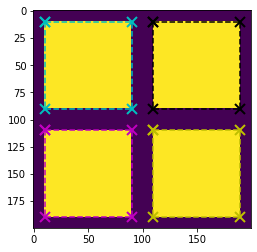

In [104]:
## An image of a rect and the ground-truth points
img, rect_pts, edges = make_4sq_img(scale_by=2)
fig, ax = plt.subplots()
ax.imshow(img)
plot_rect_pts(ax, rect_pts, edges, markersize=10, markeredgewidth=2)

### Generate a random homography matrix
This matrix is what we'll try to estimate using our DLT approach

In [127]:
# Here H is the random Homography matrix
H = MakeTf2d.projective(
        theta=rand_rng(-0.9, 0.1),
        phi=rand_rng(-0.9, 0.1),
        scale_x=rand_rng(0.9, 1.1),
        scale_y=rand_rng(0., 1.1), 
        t_x=rand_rng(10, 100), 
        t_y=rand_rng(10, 100),
        v_x=rand_rng(-0.001, 0.001),
        v_y=rand_rng(-0.001, 0.001),
)

# ## A Known projective geometry transform
# H = np.matrix([
#     [ -0.427245,  -0.516691, 200.792453],
#     [  0.312508,  -0.214305, 100.988275],
#     [ -0.000341,   0.000091,   1.      ],
# ])


### Transform the image and image points using *H* 
The new image points with serve as the target points

In [128]:
# The image's rect_pts, this will be our target points
target_pts = mult_img_pts(H, rect_pts)
w = int(max(img.shape[1], max(target_pts[:, 0])))
h = int(max(img.shape[0], max(target_pts[:, 1])))
# Let's transform the original image with this homography matrix
img_ = cv2.warpPerspective(img, H, (w, h))


### Let's draw them side-by-side

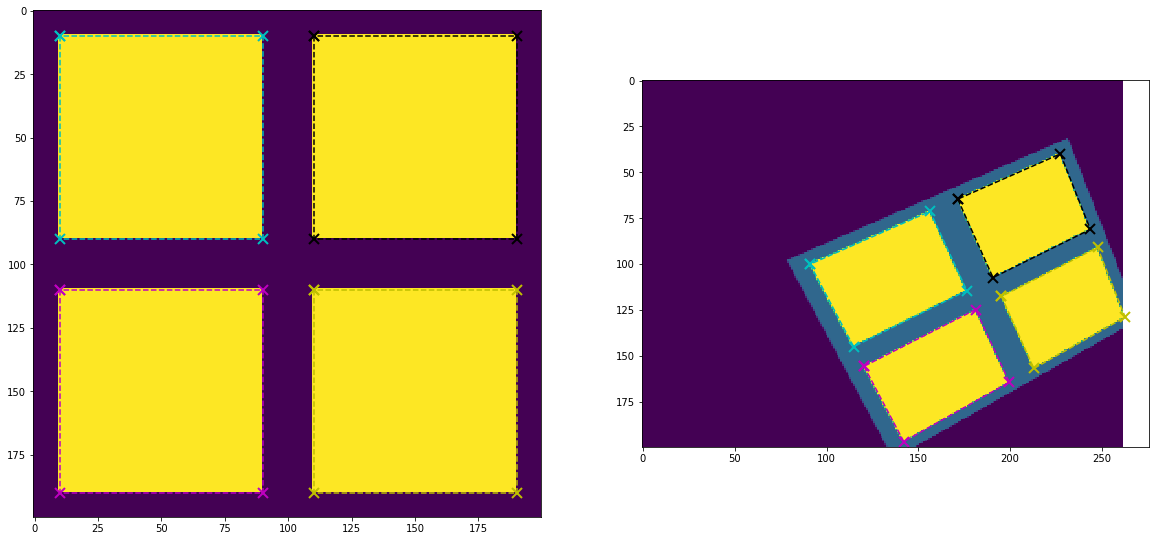

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img)
plot_rect_pts(ax[0], rect_pts, edges, markersize=10, markeredgewidth=2)
ax[1].imshow(img_)
plot_rect_pts(ax[1], target_pts, edges, markersize=10, markeredgewidth=2)

### Now let's convert it to this form

![alt text](../../images/ch_4_dlt_derivation_eq_4_3.png "Logo Title Text 1")

### (ii) Assemble $n$ $2\times9$ matrices $A_i$ into a single $2n\times9$ matrix $A$ 

In [311]:
rand_pts = np.random.randint(0, high=16, size=6)
src_pts, dst_pts = rect_pts[rand_pts], target_pts[rand_pts]
n = len(src_pts)

A_i = []
for i in range(n):
    x_i = src_pts[i]
    xp_i, yp_i, wp_i = dst_pts[i]
    
    A = np.zeros((2, 9))
    A[0, 0:3] = 0
    A[0, 3:6] = -wp_i * x_i
    A[0, 6:9] =  yp_i * x_i
    A[1, 0:3] =  wp_i * x_i
    A[1, 3:6] =  0
    A[1, 6:9] = -xp_i * x_i
    A_i.append(A)

A = np.concatenate(A_i)

## (iii) Obtain SVD of A

In [312]:
u, d, vt = np.linalg.svd(A)
V = vt.transpose()
## We are solving A.h = 0, so h is going to be the V col that corresponds to the smallest singular value
smallest_singular_value = np.argmin(d)
h = V[:, smallest_singular_value]
h /= h[-1]   ## Divide out to make the last ele
H_est = np.matrix(h.reshape(3, 3))

print("Homograhpy Estimated\n")
print(repr(H_est))
print("\nHomograhpy Expected:\n")
print(repr(H))


Homograhpy Estimated

matrix([[ 0.96218884,  0.35651844, 79.02969579],
        [-0.30433924,  0.63933877, 98.07523657],
        [ 0.00085402,  0.00048576,  1.        ]])

Homograhpy Expected:

matrix([[ 0.96218884,  0.35651844, 79.02969579],
        [-0.30433924,  0.63933877, 98.07523657],
        [ 0.00085402,  0.00048576,  1.        ]])


### Accuracy variance on number of points used

Let's see the solution accuracy varies on as we increase the number of points we provide, starting with 3 all the way upto all the points we have.
We will run the experiment 10,000 times for each number of points and analyze the results

In [453]:
def solve_homography_dlt(src_pts, dst_pts):
    n = len(src_pts)

    A_i = []
    for i in range(n):
        x_i = src_pts[i]
        xp_i, yp_i, wp_i = dst_pts[i]

        A = np.zeros((2, 9))
        A[0, 0:3] = 0
        A[0, 3:6] = -wp_i * x_i
        A[0, 6:9] =  yp_i * x_i
        A[1, 0:3] =  wp_i * x_i
        A[1, 3:6] =  0
        A[1, 6:9] = -xp_i * x_i
        A_i.append(A)

    A = np.concatenate(A_i)

    u, d, vt = np.linalg.svd(A)
    V = vt.transpose()
    ## We are solving A.h = 0, so h is going to be the V col that corresponds to the smallest singular value
    smallest_singular_value = np.argmin(d)
    h = V[:, smallest_singular_value]
    h /= h[-1]   ## Divide out to make the last ele
    H_est = np.matrix(h.reshape(3, 3))
    return H_est


def calc_SSE(H, src_pts, dst_pts):
    est_pts = mult_img_pts(H, src_pts)
    return np.sum((est_pts - dst_pts)**2)

In [454]:
N = len(rect_pts)
repeat = 10000

src_pts, dst_pts = rect_pts, target_pts

errors = {}
for p in range(4, N):
    total_error = 0
    for r in range(repeat):
        rand_idx = np.random.randint(0, high=N, size=p)
        x, x_p = src_pts[rand_idx], dst_pts[rand_idx]
        H_est = solve_homography_dlt(x, x_p)
        total_error += calc_SSE(H_est, x, x_p)
    errors[p] = np.round(total_error, 10)/repeat


{4: 122952.92979435784,
 5: 827.8474278918526,
 6: 162.33346898881575,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0}

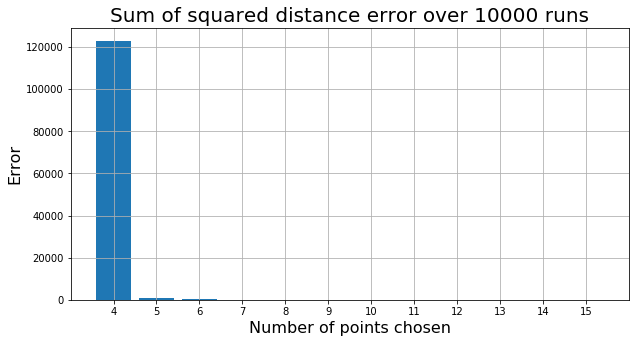

In [455]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Sum of squared distance error over {} runs'.format(repeat), fontsize=20)
ax.bar(list(errors.keys()), (list(errors.values())))
ax.grid(True)
ax.set_xticks(list(errors.keys()))
ax.set_ylabel('Error', fontsize=16)
ax.set_xlabel('Number of points chosen', fontsize=16)
errors_1 = errors
errors_1

### Observation 1 
In the plot above, notice how randomly picking 3 (the *minimum*) points we didn't always end-up of the correct result. As we use more and more points we get better results. 

### Observation 2
Using 7+ points we got the most reliable results, but using 3-6 points returned results that are often incorrect enough to be unreliable. 
This doesn't mean that we minimum 7+ points to accurately estimate homography using this method. 

The real reason for this issue is that the points for the `rect_pts` that are being used all the edge points, so there is a high probability that if we randomly pick points they could be colinear or from parallel lines. So if we randomly pick points we'll get a far better result.


{4: 0.19739579815246,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0}

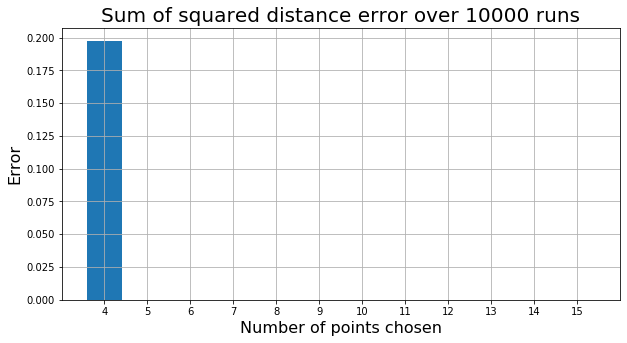

In [456]:
N = len(rect_pts)
repeat = 10000

## randomly generate src_pts and dst_pts
src_pts = np.random.random((N, 3)) * 100 + 100
src_pts[:, -1] = 1
dst_pts = mult_img_pts(H, src_pts)

errors = {}
for p in range(4, N):
    total_error = 0
    for r in range(repeat):
        rand_idx = np.random.randint(0, high=N, size=p)
        x, x_p = src_pts[rand_idx], dst_pts[rand_idx]
        H_est = solve_homography_dlt(x, x_p)
        total_error += calc_SSE(H_est, x, x_p)
    errors[p] = np.round(total_error, 10)/repeat
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Sum of squared distance error over {} runs'.format(repeat), fontsize=20)
ax.bar(list(errors.keys()), (list(errors.values())))
ax.grid(True)
ax.set_xticks(list(errors.keys()))
ax.set_ylabel('Error', fontsize=16)
ax.set_xlabel('Number of points chosen', fontsize=16)
errors_2 = errors
errors_2

Text(0.5, 0, 'Number of points chosen')

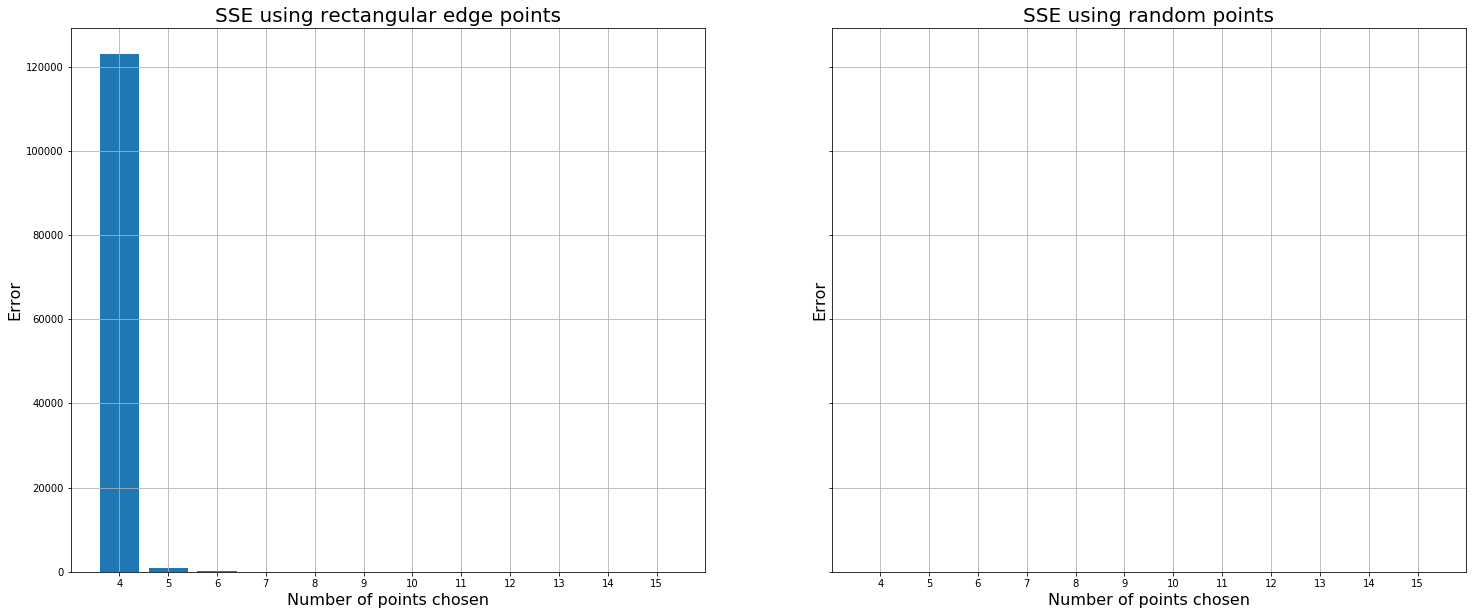

In [457]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey=True)
ax1.set_title('SSE using rectangular edge points', fontsize=20)
ax1.bar(list(errors_1.keys()), (list(errors_1.values())))
ax1.grid(True)
ax1.set_xticks(list(errors_1.keys()))
ax1.set_ylabel('Error', fontsize=16)
ax1.set_xlabel('Number of points chosen', fontsize=16)
ax2.set_title('SSE using random points', fontsize=20)
ax2.bar(list(errors_2.keys()), (list(errors_2.values())))
ax2.grid(True)
ax2.set_xticks(list(errors_2.keys()))
ax2.set_ylabel('Error', fontsize=16)
ax2.set_xlabel('Number of points chosen', fontsize=16)
